# MNIST tutorial
https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


let's try learning the mnist dataset

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt

In [65]:
sample_input = torch.randn(1, 1, 28, 28)
print(f"input shape: {sample_input.shape}")

sample_conv2d = nn.Conv2d(1, 5, 4)(sample_input)
print(f"shape after convolution: {sample_conv2d.shape}")

sample_dropout = nn.Dropout(0.8)(sample_input)
num_elements_all = torch.numel(sample_input)
print(f"number of elements in tensor: {num_elements_all}")
print(f"number of zero elements at beginning: {torch.sum(sample_input == 0)}")
num_zeros_afterdropout = torch.sum(sample_dropout == 0)
print(f"number of zero elements after dropout: {num_zeros_afterdropout}")
print(f"ratio of zero elements after dropout: {num_zeros_afterdropout/num_elements_all}")

input shape: torch.Size([1, 1, 28, 28])
shape after convolution: torch.Size([1, 5, 25, 25])
number of elements in tensor: 784
number of zero elements at beginning: 0
number of zero elements after dropout: 648
ratio of zero elements after dropout: 0.8265306353569031


try changing the network structure and see if it can still learn

the structure below is way overkill, a one-layer network can still learn fairly well

In [99]:
# define network structure
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # first 2D convolutional layer taking 1 input channel
        # outputting 32 convolutional features, with kernel size 3
        # Conv2d(in_channels, out_channels, kernel_size, stride)
        # output height and width are determined automatically
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # second 2D convolutional layer taking 32 input channels
        # outputting 64 convolutional features, with kernel size 3
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        # During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution. 
        # Each channel will be zeroed out independently on every forward call.
        # This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # first fc layer
        self.fc1 = nn.Linear(9216, 128)
        # second fc layer
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)

        # run max pooling
        x = F.max_pool2d(x, 2)
        # pass data through dropout layer
        x = self.dropout1(x)
        # flatten x with start_dim=1
        x = torch.flatten(x, 1)

        # fc layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        # apply softmax
        output = F.log_softmax(x, dim=1)
        return output

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


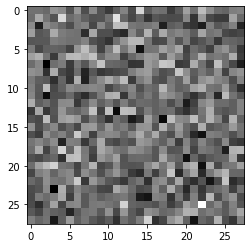

tensor([[-2.2999, -2.2029, -2.6407, -2.4541, -2.2039, -2.3288, -2.2663, -2.3806,
         -2.1603, -2.1827]], grad_fn=<LogSoftmaxBackward0>)


In [93]:
my_nn = Net()
print(my_nn)

# pass random data through network
random_data = torch.randn((1, 1, 28, 28))
plt.imshow(random_data[0, 0, :, :], cmap='gray')
plt.show()
result = my_nn(random_data)
print(result)

In [94]:
# load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('./', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('./', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

there are 64 images in the batch, showing the first 3...


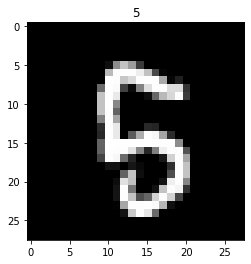

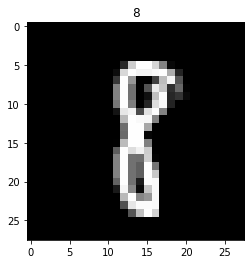

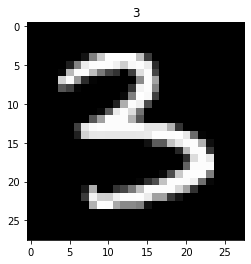

In [95]:
# visualize data
dataiter = iter(trainloader)
# get random training image
images, labels = dataiter.next()
print(f"there are {len(images)} images in the batch, showing the first 3...")
for i in range(3):
    # plot image
    plt.imshow(images[i][0], cmap='gray')
    # print label
    plt.title(classes[labels[i]])
    plt.show()

In [96]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_nn.parameters(), lr=0.001)

In [97]:
epochs = 1
loss_list = []
for epoch in range(epochs):
    running_loss = 0.
    # length of trainloader
    print(f"there are {len(trainloader)} batches in the trainloader")
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # reset gradients
        optimizer.zero_grad()
        # forward pass
        outputs = my_nn(inputs)
        # calculate loss
        loss = criterion(outputs, labels)
        # backpropagate
        loss.backward()
        # update weights
        optimizer.step()

        running_loss += loss.item()
        loss_list.append(loss.item())
    print('Epoch: {} - Loss: {}'.format(epoch, running_loss/len(trainloader)))
    torch.save(my_nn.state_dict(), f'./model_epoch{epoch}.pt')
    running_loss = 0.

there are 938 batches in the trainloader
Epoch: 0 - Loss: 0.2143299311204855


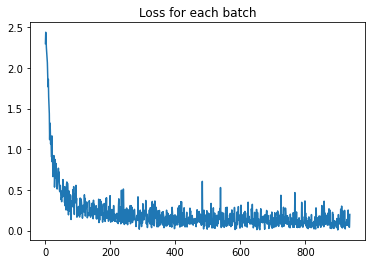

In [98]:
plt.plot(loss_list)
plt.title('Loss for each batch')
plt.show()

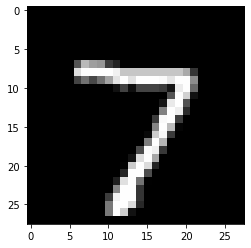

actual: 7
predicted: 7


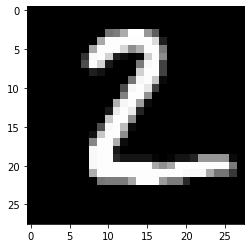

actual: 2
predicted: 2


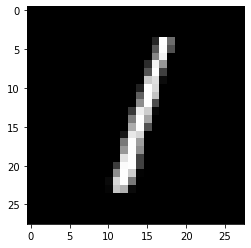

actual: 1
predicted: 1


In [87]:
# test it on some test images
dataiter = iter(testloader)
images, labels = dataiter.next()
prediction = my_nn(images)
for i in range(3):
    image, label = images[i], labels[i]
    plt.imshow(image[0], cmap='gray')
    plt.show()
    print(f"actual: {label.item()}")
    print(f"predicted: {prediction[i].argmax().item()}")